In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import sys
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import io

# Flagstat

In [2]:
dpath = "/scratch/indikar_root/indikar1/cstansbu/scpc_test/reports/flagstat/"

def read_flagstat(fpath):
    """A hacky function to read the important lines of 
    the samtools flagstat report """
    keepers = [0, 1, 2, 3, 6, 7, 8, 9]
    tmp = pd.read_csv(fpath, 
                      sep='\t', 
                      header=None)
    tmp.columns = ['value', 'drop', 'metric']
    tmp = tmp.iloc[keepers]
    tmp = tmp[['metric', 'value']]
    tmp['value'] = tmp['value'].apply(lambda x: x.replace("%", ""))
    tmp['value'] = tmp['value'].astype(float)
    return tmp

df = []
for f in os.listdir(dpath):
    fpath = f"{dpath}{f}"
    sample = f[:2]
    cell = f[2:5]
    ref = f.split(".")[1]

    tmp = read_flagstat(fpath)
    tmp['cell'] = cell
    tmp['sample'] = sample
    tmp['ref'] = ref
    df.append(tmp)


df = pd.concat(df)
df = pd.pivot_table(df, index=['sample', 'cell', 'ref'],
                    columns='metric',
                    values='value').reset_index()
df.head()

metric,sample,cell,ref,mapped,mapped %,primary,primary mapped,primary mapped %,secondary,supplementary,total (QC-passed reads + QC-failed reads)
0,o1,b01,129S1_SvImJ,3979.0,56.27,4898.0,1806.0,36.87,1380.0,793.0,7071.0
1,o1,b01,CAST_EiJ,3906.0,55.81,4898.0,1805.0,36.85,1315.0,786.0,6999.0
2,o1,b01,GRCm39,4168.0,57.58,4898.0,1827.0,37.30,1573.0,768.0,7239.0
3,o1,b02,129S1_SvImJ,2597504.0,86.65,1520695.0,1120665.0,73.69,879375.0,597464.0,2997534.0
4,o1,b02,CAST_EiJ,2569831.0,86.16,1520695.0,1107777.0,72.85,851304.0,610750.0,2982749.0


In [3]:
# clean up before exporting

pdf = df.copy()

pdf.columns

pdf.columns = [
    'Sample',
    'Barcode',
    'Reference',
    'Reads Mapped',
    'Reads Mapped (%)',
    'Primary Alignments',
    'Primary Alignments Mapped',
    'Primary Alignments Mapped (%)',
    'Secondary Alignments',
    'Supplementary Alignments',
    'Total Alignment Attempts',
]

pdf.head()

,Sample,Barcode,Reference,Reads Mapped,Reads Mapped (%),Primary Alignments,Primary Alignments Mapped,Primary Alignments Mapped (%),Secondary Alignments,Supplementary Alignments,Total Alignment Attempts
0,o1,b01,129S1_SvImJ,3979.0,56.27,4898.0,1806.0,36.87,1380.0,793.0,7071.0
1,o1,b01,CAST_EiJ,3906.0,55.81,4898.0,1805.0,36.85,1315.0,786.0,6999.0
2,o1,b01,GRCm39,4168.0,57.58,4898.0,1827.0,37.30,1573.0,768.0,7239.0
3,o1,b02,129S1_SvImJ,2597504.0,86.65,1520695.0,1120665.0,73.69,879375.0,597464.0,2997534.0
4,o1,b02,CAST_EiJ,2569831.0,86.16,1520695.0,1107777.0,72.85,851304.0,610750.0,2982749.0


In [4]:
# generate the summary
gx = pdf.groupby(['Sample', 'Reference']).agg(
    Total_Reads_Mapped = ('Reads Mapped', 'sum'),
    Mean_Reads_Mapped = ('Reads Mapped', 'mean'),
    Mean_Reads_Mapped_Percent = ('Reads Mapped (%)', 'mean'),
    Total_Primary_Alignments_Mapped = ('Primary Alignments Mapped', 'sum'),
    Total_Secondary_Alignments_Mapped = ('Secondary Alignments', 'sum'),
    Total_Alignment_Attempts = ('Total Alignment Attempts', 'sum'),
    Mean_Alignment_Attempts = ('Total Alignment Attempts', 'mean'),
    
).reset_index().round(3)

outpath = "/scratch/indikar_root/indikar1/cstansbu/scpc_test/analysis/excel_reports/flagstat_summary.xlsx"

with pd.ExcelWriter(outpath, engine='xlsxwriter') as writer:
    # summary as the first tab
    gx.to_excel(writer, sheet_name='Alignment_Summary', index=False)

    # save each sample to a new tab
    for group_names, group in pdf.groupby(['Sample', 'Reference']):
        sample, ref = group_names
        group.to_excel(writer, sheet_name=f"AS_{sample}_{ref}", index=False)

print(f'saved: {outpath}')

saved: /scratch/indikar_root/indikar1/cstansbu/scpc_test/analysis/excel_reports/flagstat_summary.xlsx


# Histograms

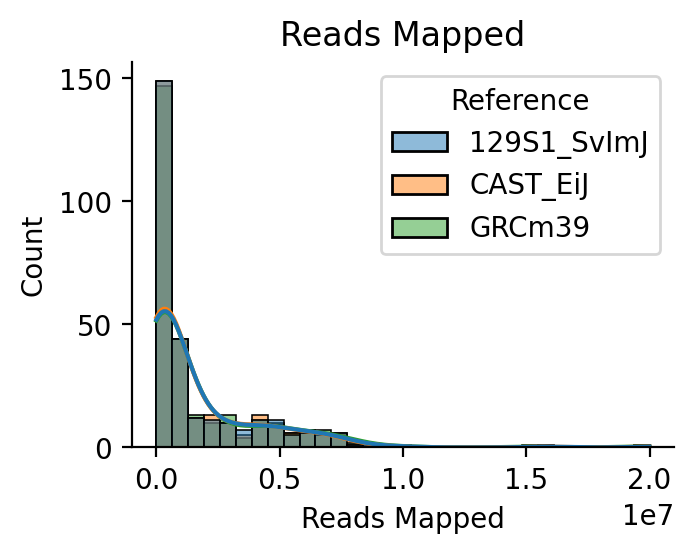

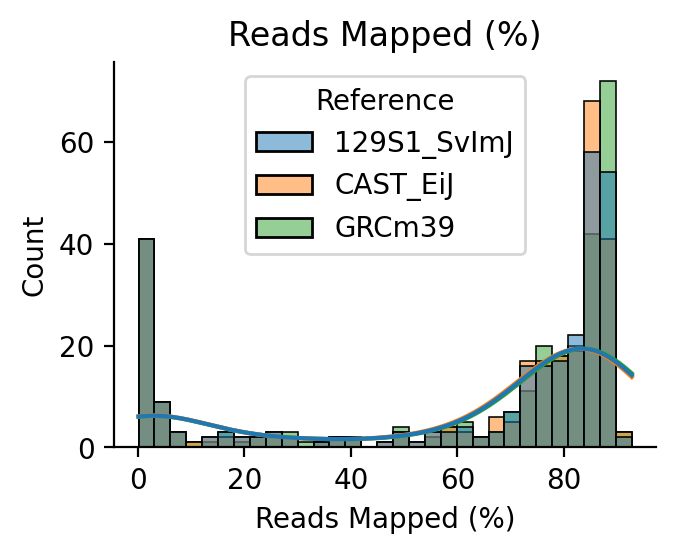

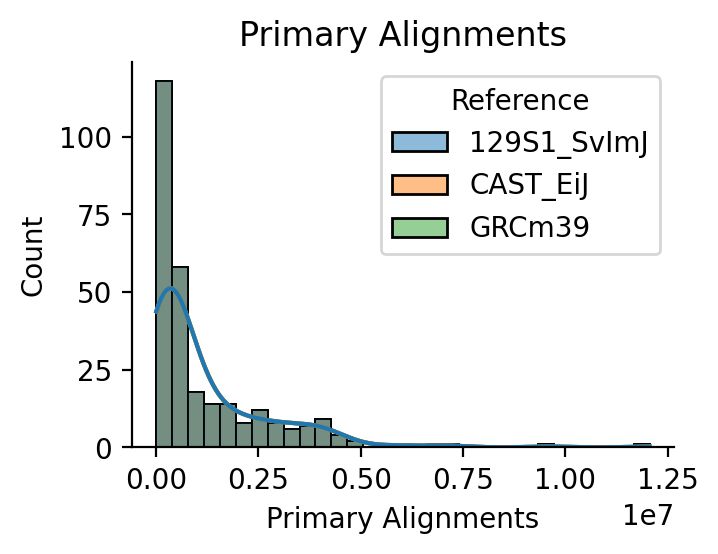

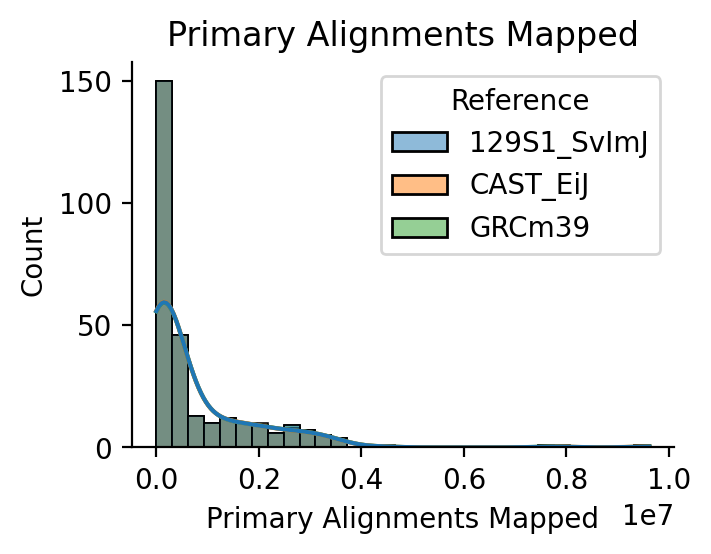

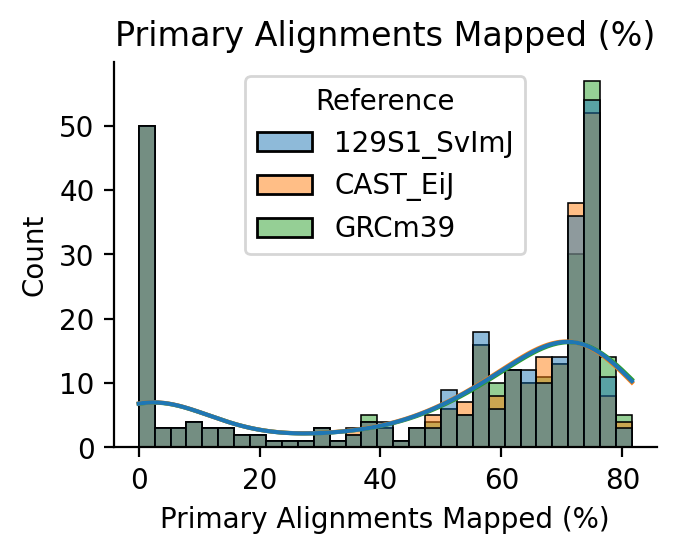

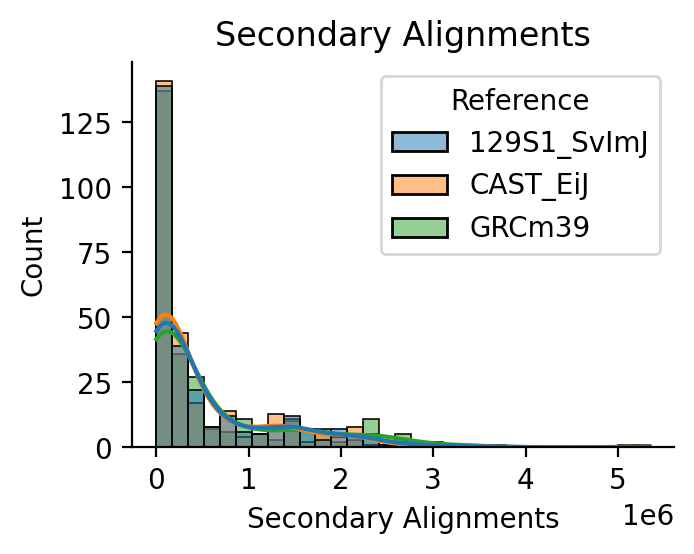

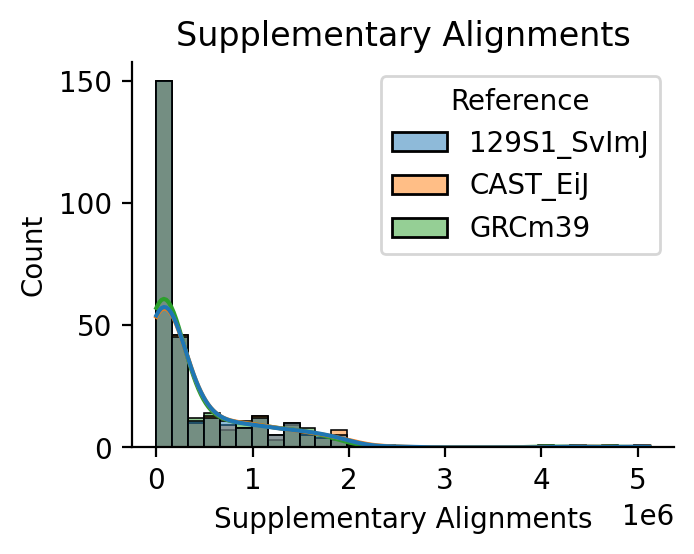

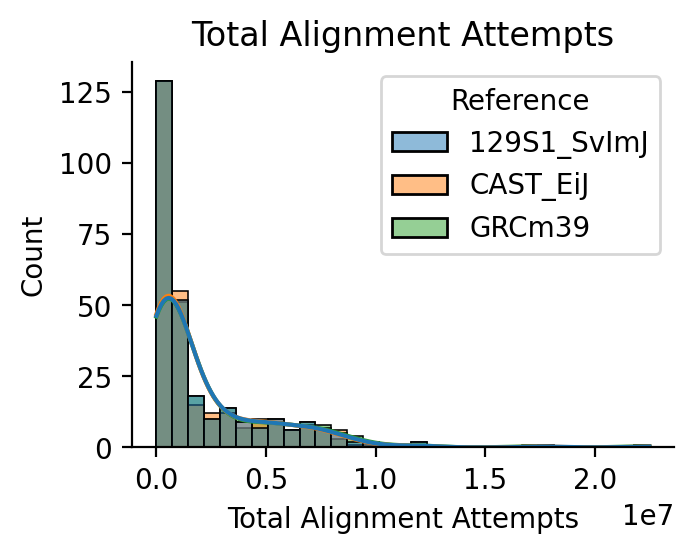

In [5]:
plot_cols = [
    'Reads Mapped',
    'Reads Mapped (%)',
    'Primary Alignments',
    'Primary Alignments Mapped',
    'Primary Alignments Mapped (%)',
    'Secondary Alignments',
    'Supplementary Alignments',
    'Total Alignment Attempts',  
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2.5

for c in plot_cols:
    sns.histplot(data=pdf, 
                 x=c,
                 hue='Reference',
                 bins=31,
                 kde=True)

    plt.title(c)
    sns.despine()
    plt.show()

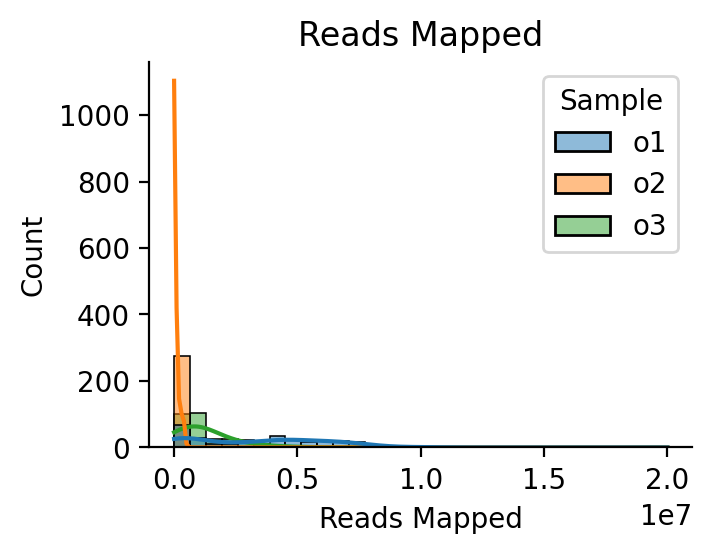

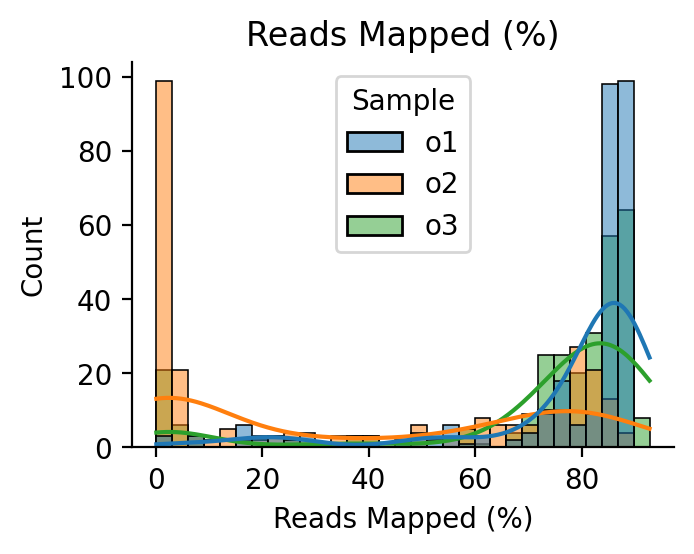

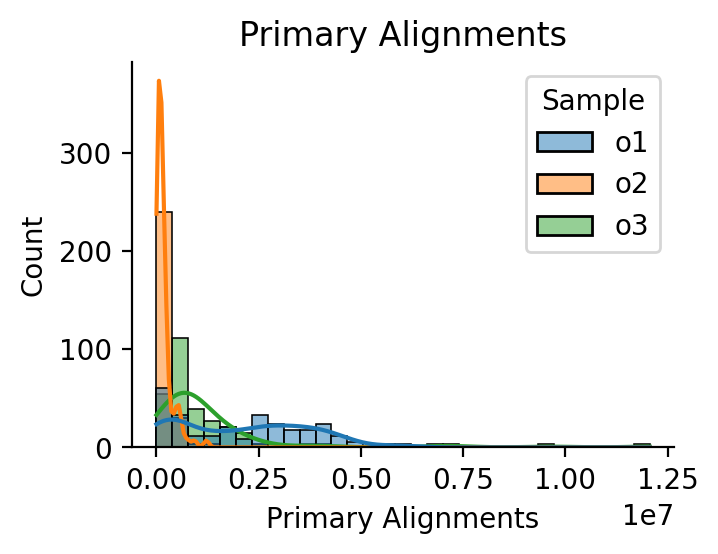

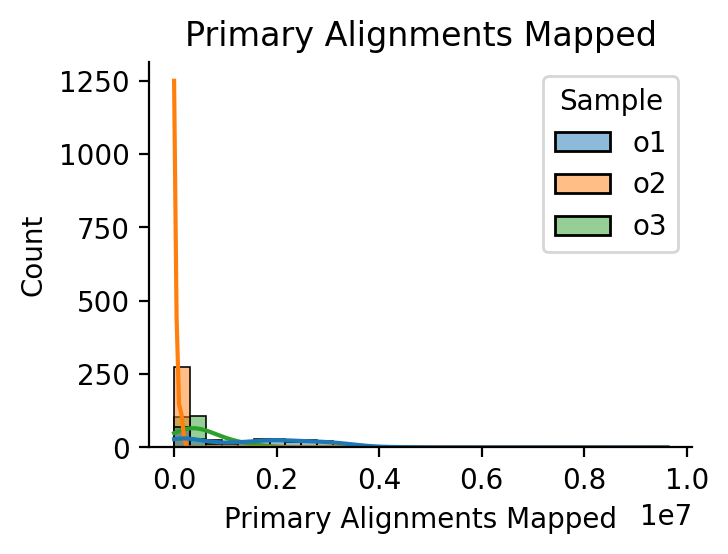

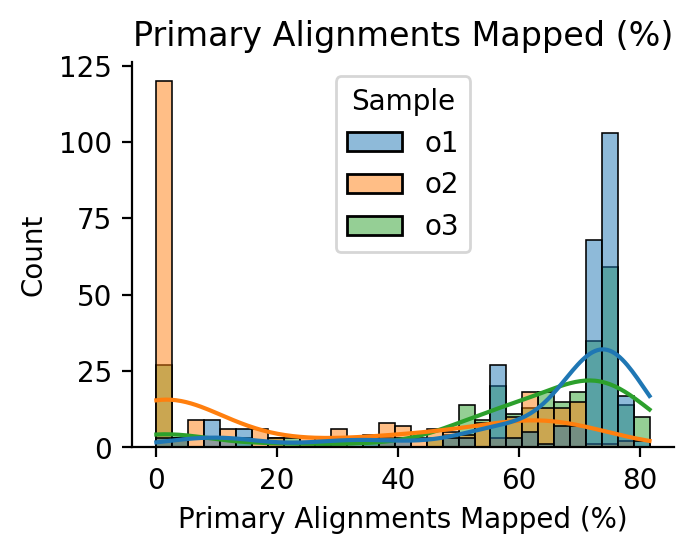

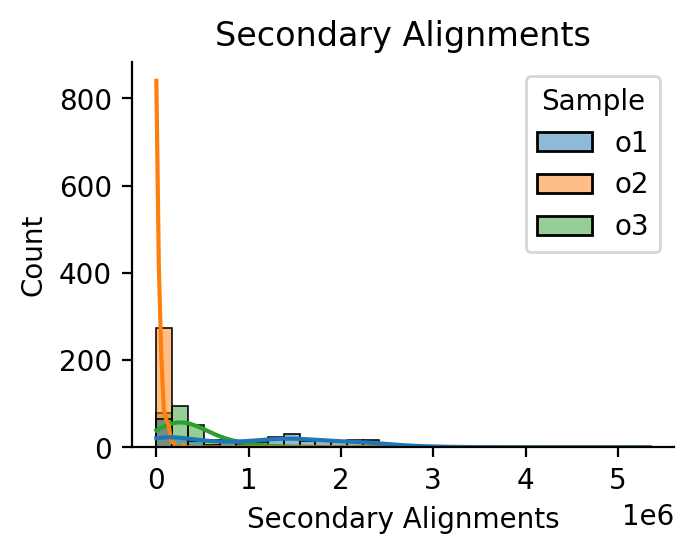

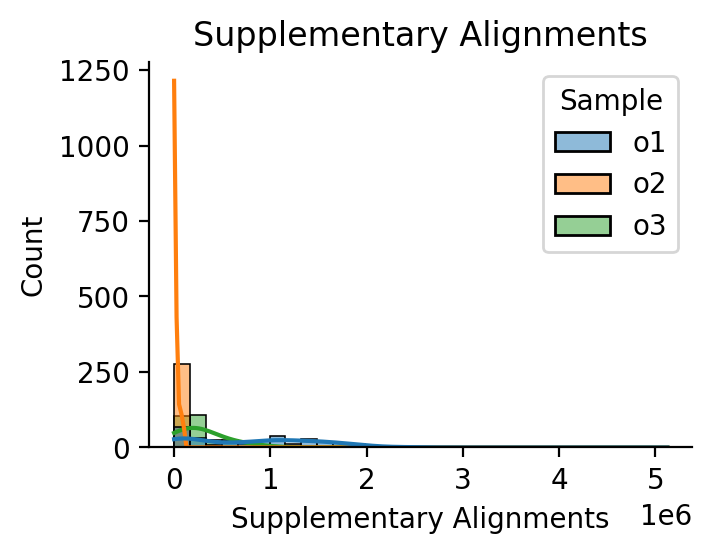

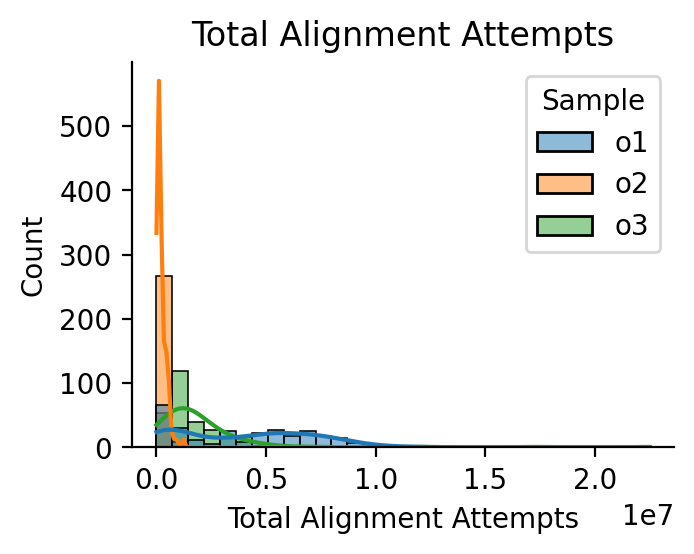

In [6]:
plot_cols = [
    'Reads Mapped',
    'Reads Mapped (%)',
    'Primary Alignments',
    'Primary Alignments Mapped',
    'Primary Alignments Mapped (%)',
    'Secondary Alignments',
    'Supplementary Alignments',
    'Total Alignment Attempts',  
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2.5

for c in plot_cols:
    sns.histplot(data=pdf, 
                 x=c,
                 hue='Sample',
                 bins=31,
                 kde=True)

    plt.title(c)
    sns.despine()
    plt.show()

# Specific analysis 

In [9]:
pdf.head()

,Sample,Barcode,Reference,Reads Mapped,Reads Mapped (%),Primary Alignments,Primary Alignments Mapped,Primary Alignments Mapped (%),Secondary Alignments,Supplementary Alignments,Total Alignment Attempts
0,o1,b01,129S1_SvImJ,3979.0,56.27,4898.0,1806.0,36.87,1380.0,793.0,7071.0
1,o1,b01,CAST_EiJ,3906.0,55.81,4898.0,1805.0,36.85,1315.0,786.0,6999.0
2,o1,b01,GRCm39,4168.0,57.58,4898.0,1827.0,37.30,1573.0,768.0,7239.0
3,o1,b02,129S1_SvImJ,2597504.0,86.65,1520695.0,1120665.0,73.69,879375.0,597464.0,2997534.0
4,o1,b02,CAST_EiJ,2569831.0,86.16,1520695.0,1107777.0,72.85,851304.0,610750.0,2982749.0


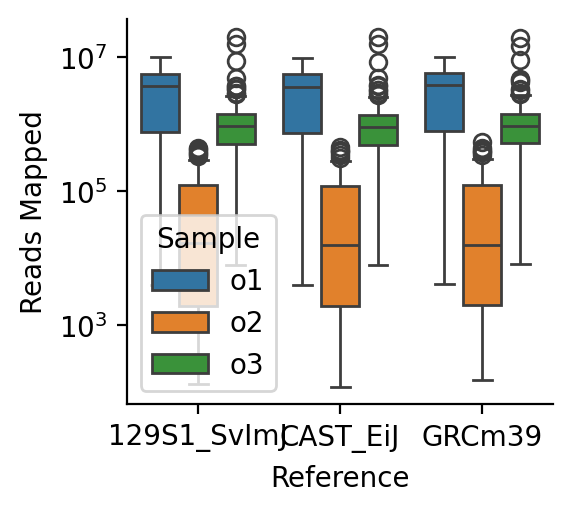

In [14]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2.5, 2.5

sns.boxplot(data=pdf,
            y="Reads Mapped",
            x='Reference',
            hue='Sample')

plt.yscale('log')

ax = plt.gca()
sns.despine()
plt.show()
